In [1]:
%reload_ext nb_black

<IPython.core.display.Javascript object>

## Day 32 Lecture 1 Assignment

In this assignment, we will learn about K nearest neighbor regression. We will use the absenteeism at work dataset loaded below and analyze the model generated for this dataset.

The meaning of the different columns can be found here: https://www.kaggle.com/tonypriyanka2913/employee-absenteeism

In [22]:
%matplotlib inline

import math

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.neighbors import KNeighborsRegressor

import warnings

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor


<IPython.core.display.Javascript object>

In [3]:
absent = pd.read_csv(
    "https://tf-assets-prod.s3.amazonaws.com/tf-curric/data-science/Absenteeism_at_work.csv",
    sep=";",
)

<IPython.core.display.Javascript object>

In [4]:
absent.shape

(740, 21)

<IPython.core.display.Javascript object>

In [5]:
pd.set_option("display.max_columns", None)
absent.head()

,ID,Reason for absence,Month of absence,Day of the week,Seasons,Transportation expense,Distance from Residence to Work,Service time,Age,Work load Average/day,Hit target,Disciplinary failure,Education,Son,Social drinker,Social smoker,Pet,Weight,Height,Body mass index,Absenteeism time in hours
0,11,26,7,3,1,289,36,13,33,239.554,97,0,1,2,1,0,1,90,172,30,4
1,36,0,7,3,1,118,13,18,50,239.554,97,1,1,1,1,0,0,98,178,31,0
2,3,23,7,4,1,179,51,18,38,239.554,97,0,1,0,1,0,0,89,170,31,2
3,7,7,7,5,1,279,5,14,39,239.554,97,0,1,2,1,1,0,68,168,24,4
4,11,23,7,5,1,289,36,13,33,239.554,97,0,1,2,1,0,1,90,172,30,2


<IPython.core.display.Javascript object>

Find which variables have the highest pairwise correlation and remove them from our dataset. Additionally, try to think of which variables are correlated by looking at the column names and remove those columns as well.

Note: When choosing between two categorical variables that are correlated, you often want to keep the one with fewer unique values. Why might that be? (Think about the cons of KNN.)

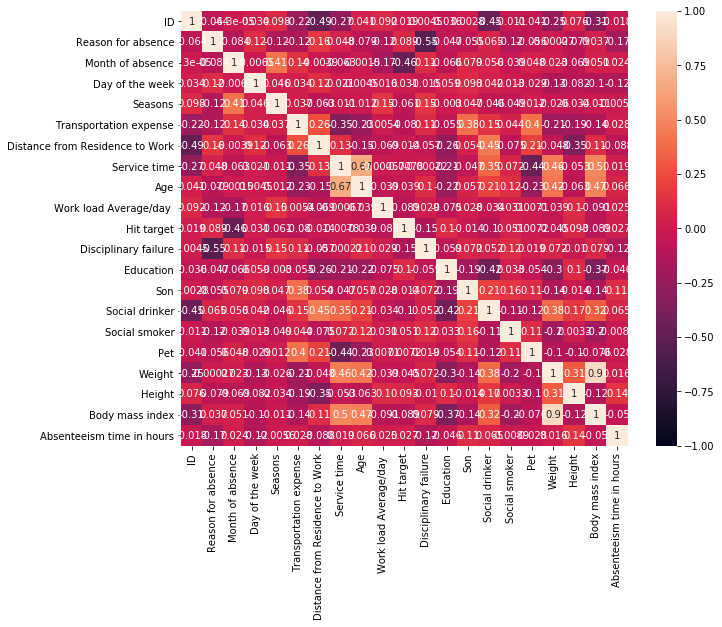

<IPython.core.display.Javascript object>

In [6]:
# answer below:
plt.figure(figsize=(10, 8))

sns.heatmap(absent.corr(), vmin=-1, vmax=1, annot=True)

In [7]:
absent = absent.drop(columns=(["Body mass index", "ID", "Seasons"]))

<IPython.core.display.Javascript object>

In [8]:
absent.head()

,Reason for absence,Month of absence,Day of the week,Transportation expense,Distance from Residence to Work,Service time,Age,Work load Average/day,Hit target,Disciplinary failure,Education,Son,Social drinker,Social smoker,Pet,Weight,Height,Absenteeism time in hours
0,26,7,3,289,36,13,33,239.554,97,0,1,2,1,0,1,90,172,4
1,0,7,3,118,13,18,50,239.554,97,1,1,1,1,0,0,98,178,0
2,23,7,4,179,51,18,38,239.554,97,0,1,0,1,0,0,89,170,2
3,7,7,5,279,5,14,39,239.554,97,0,1,2,1,1,0,68,168,4
4,23,7,5,289,36,13,33,239.554,97,0,1,2,1,0,1,90,172,2


<IPython.core.display.Javascript object>

In [9]:
absent.columns

Index(['Reason for absence', 'Month of absence', 'Day of the week',
       'Transportation expense', 'Distance from Residence to Work',
       'Service time', 'Age', 'Work load Average/day ', 'Hit target',
       'Disciplinary failure', 'Education', 'Son', 'Social drinker',
       'Social smoker', 'Pet', 'Weight', 'Height',
       'Absenteeism time in hours'],
      dtype='object')

<IPython.core.display.Javascript object>

In [10]:
absent["Month of absence"].value_counts()

3     87
2     72
10    71
7     67
5     64
11    63
8     54
6     54
9     53
4     53
1     50
12    49
0      3
Name: Month of absence, dtype: int64

<IPython.core.display.Javascript object>

In [11]:
month_counts = absent["Month of absence"].value_counts()
keep = month_counts[month_counts > 4].index
absent = absent[absent["Month of absence"].isin(keep)]

<IPython.core.display.Javascript object>

In [12]:
absent["Reason for absence"].value_counts()

23    149
28    112
27     69
13     55
0      40
19     40
22     38
26     33
25     31
11     26
10     25
18     21
14     19
1      16
7      15
6       8
12      8
8       6
21      6
9       4
5       3
24      3
16      3
4       2
15      2
3       1
2       1
17      1
Name: Reason for absence, dtype: int64

<IPython.core.display.Javascript object>

In [13]:
counts = absent["Reason for absence"].value_counts()
counts = counts[counts > 8]
keep_reasons = counts.index

absent = absent[absent["Reason for absence"].isin(keep_reasons)]

<IPython.core.display.Javascript object>

Figure out which columns actually contain sneaky categorical variables and turn those into dummy variables.

In [14]:
absent.columns

Index(['Reason for absence', 'Month of absence', 'Day of the week',
       'Transportation expense', 'Distance from Residence to Work',
       'Service time', 'Age', 'Work load Average/day ', 'Hit target',
       'Disciplinary failure', 'Education', 'Son', 'Social drinker',
       'Social smoker', 'Pet', 'Weight', 'Height',
       'Absenteeism time in hours'],
      dtype='object')

<IPython.core.display.Javascript object>

In [15]:
absent["Day of the week"].value_counts()

2    152
4    143
3    139
6    137
5    118
Name: Day of the week, dtype: int64

<IPython.core.display.Javascript object>

In [16]:
# answer below:
cat_col = [
    "Month of absence",
    "Day of the week",
    "Reason for absence",
    "Disciplinary failure",
    "Education",
    "Social drinker",
    "Social smoker",
    "Pet",
]
drop_cats = [3, 2, 23, 0, 1, 1, 0, 0]
num_col = [
    "Transportation expense",
    "Distance from Residence to Work",
    "Service time",
    "Age",
    "Work load Average/day ",
    "Hit target",
    "Son",
    "Weight",
    "Height",
]

<IPython.core.display.Javascript object>

Split the data into train and test with test containing 20% of the data, then scale your features.

In [17]:
# answer below:
X = absent.drop(columns=["Absenteeism time in hours"])
y = absent["Absenteeism time in hours"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=13
)

<IPython.core.display.Javascript object>

In [18]:
absent.head()

,Reason for absence,Month of absence,Day of the week,Transportation expense,Distance from Residence to Work,Service time,Age,Work load Average/day,Hit target,Disciplinary failure,Education,Son,Social drinker,Social smoker,Pet,Weight,Height,Absenteeism time in hours
0,26,7,3,289,36,13,33,239.554,97,0,1,2,1,0,1,90,172,4
1,0,7,3,118,13,18,50,239.554,97,1,1,1,1,0,0,98,178,0
2,23,7,4,179,51,18,38,239.554,97,0,1,0,1,0,0,89,170,2
3,7,7,5,279,5,14,39,239.554,97,0,1,2,1,1,0,68,168,4
4,23,7,5,289,36,13,33,239.554,97,0,1,2,1,0,1,90,172,2


<IPython.core.display.Javascript object>

In [19]:
preprocessing = ColumnTransformer(
    [
        ("dummy", OneHotEncoder(drop=drop_cats), cat_col),
        ("scale", StandardScaler(), num_col),
    ],
    remainder="passthrough",
)

<IPython.core.display.Javascript object>

In [20]:
pipeline = Pipeline([("preprocessing", preprocessing), ("knn", KNeighborsRegressor())])

<IPython.core.display.Javascript object>

Train a series of KNN regression models with a range of K values. For each K value, use cross validation of the training set and find the average RMSE score. Make a plot of K versus average RMSE. What is the best value of K?

In [32]:
ks = np.arange(1, 100, 2)
rmses = []

for k in ks:
    pipeline.named_steps["knn"].n_neighbors = k
    neg_rmses = cross_val_score(
        pipeline, X_train, y_train, scoring="neg_root_mean_squared_error"
    )
    avg_rmse = np.mean(-neg_rmses)
    rmses.append(avg_rmse)

<IPython.core.display.Javascript object>

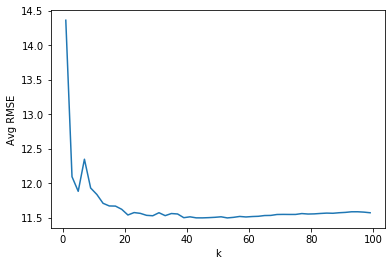

<IPython.core.display.Javascript object>

In [33]:
plt.plot(ks, rmses)
plt.xlabel("k")
plt.ylabel("Avg RMSE")
plt.show()

Using your best K, fit a model to all your training data and show the RMSE for the training and testing sets.

In [34]:
# answer below
grid = {"knn__n_neighbors": np.arange(1, 100, 4)}
model = GridSearchCV(pipeline, grid)
model.fit(X_train, y_train)

model.best_params_

{'knn__n_neighbors': 53}

<IPython.core.display.Javascript object>

In [35]:
model.score(X_train, y_train)

0.07766795506989654

<IPython.core.display.Javascript object>

In [36]:
model.score(X_test, y_test)

-0.018153084943287823

<IPython.core.display.Javascript object>

Create a homoscedasticity plot (also called residual plot). How is your model performing? What ideas do you have to improve the model?

In [ ]:
# answer below